# Exercise 3

##### Importing required packages

In [1]:
#!pip install anndata
#!pip install scanpy
#!pip install pandas
#!pip install seaborn
#!pip install matplotlib
#!pip install numpy
#!pip install python-igraph
#!pip install leidenalg
#!pip install omnipath

import anndata as ad
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import davies_bouldin_score

##### Loading data

In [2]:
adata = ad.read_h5ad('GTEX-1HSMQ-5005.h5ad')
adata

AnnData object with n_obs × n_vars = 14404 × 17695
    obs: 'n_genes', 'fpr', 'tissue', 'prep', 'individual', 'nGenes', 'nUMIs', 'PercentMito', 'PercentRibo', 'Age_bin', 'Sex', 'Sample ID', 'Participant ID', 'Sample ID short', 'RIN score from PAXgene tissue Aliquot', 'RIN score from Frozen tissue Aliquot', 'Autolysis Score', 'Sample Ischemic Time (mins)', 'Tissue Site Detail', 'scrublet', 'scrublet_score', 'barcode', 'batch', 'n_counts', 'tissue-individual-prep', 'Broad cell type', 'Granular cell type', 'introns', 'junctions', 'exons', 'sense', 'antisense', 'intergenic', 'batch-barcode', 'exon_ratio', 'intron_ratio', 'junction_ratio', 'log10_nUMIs', 'leiden', 'leiden_tissue', 'Tissue composition', 'Cell types level 2', 'Cell types level 3', 'Broad cell type numbers', 'Broad cell type (numbers)', 'Tissue', 'channel'
    var: 'gene_ids', 'Chromosome', 'Source', 'Start', 'End', 'Strand', 'gene_name', 'gene_source', 'gene_biotype', 'gene_length', 'gene_coding_length', 'Approved symbol', 'A

##### Basic Filtering

In [3]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

##### Computing mitochondrial gene fraction

In [4]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # Adjust this depending on your mitochondrial gene prefix
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

##### Data visualization

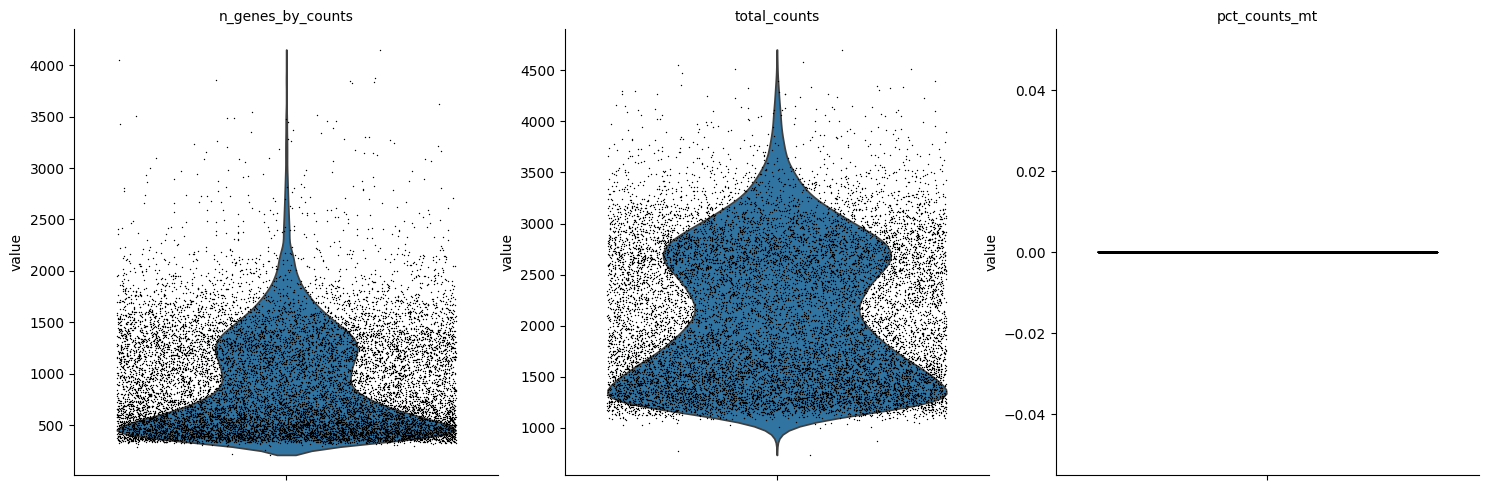

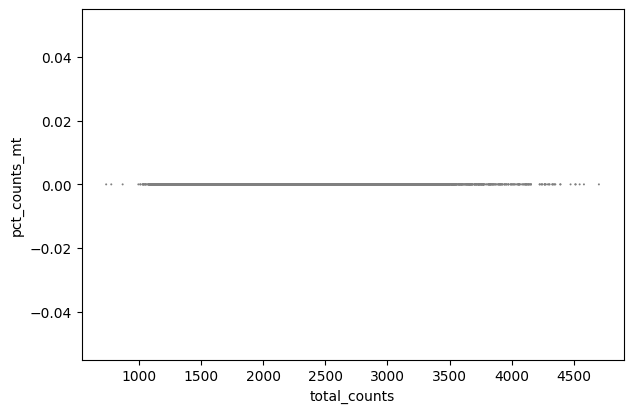

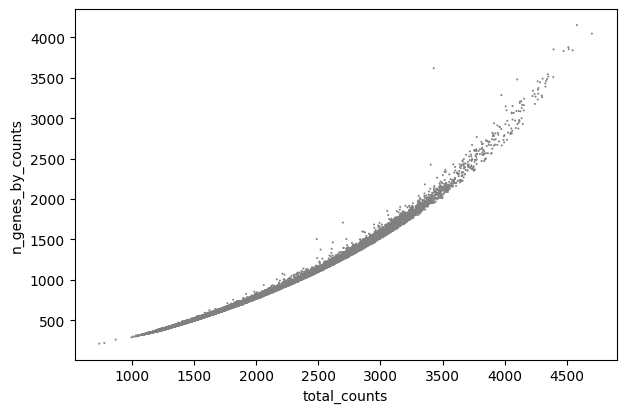

In [5]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

##### Defining different resolutions

In [6]:
resolutions = [0.1, 0.3, 0.5, 0.7, 1.0]

##### Dictionaries for storing results

In [7]:
db_scores = {'normalized': {}, 'non_normalized': {}}

C:\Users\David\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\David\AppData\Local\Temp\ipykernel_9292\1386245054.py:17: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_norm, resolution=res, key_added=f'leiden_res_{res}')


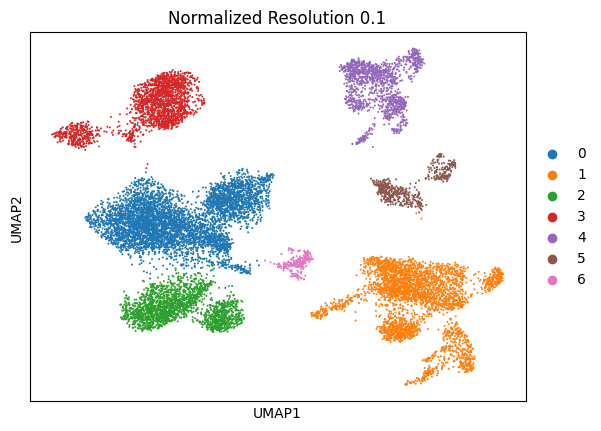

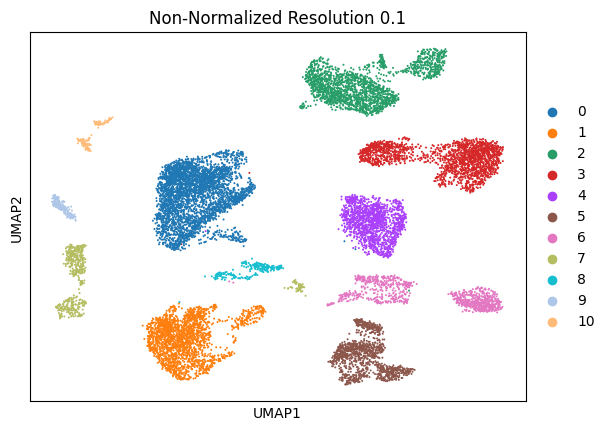

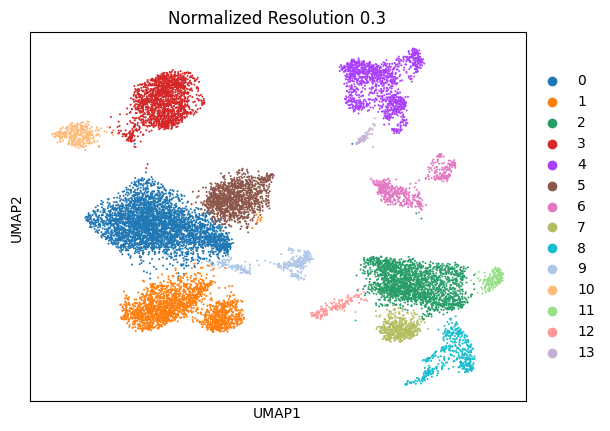

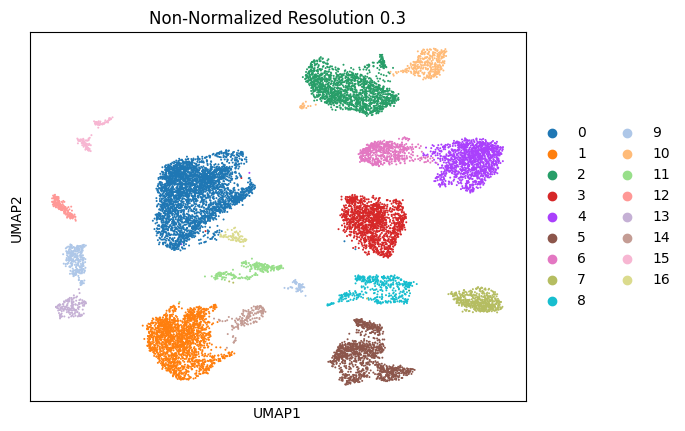

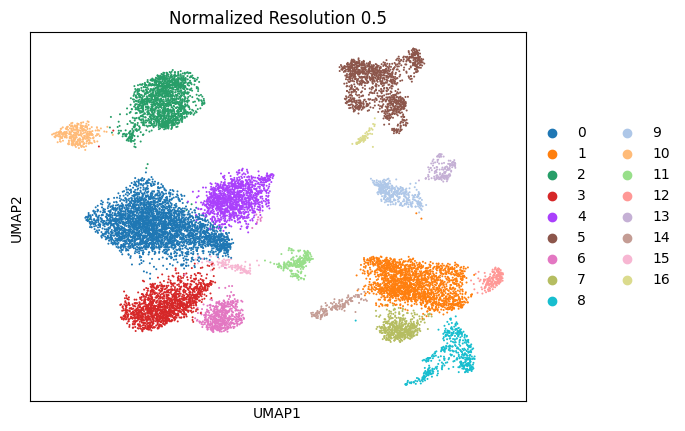

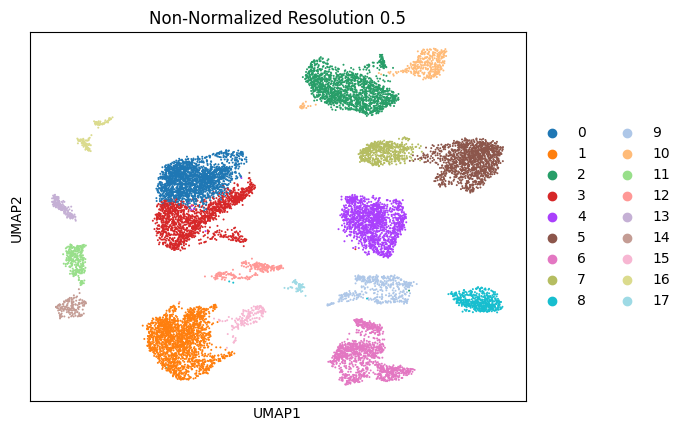

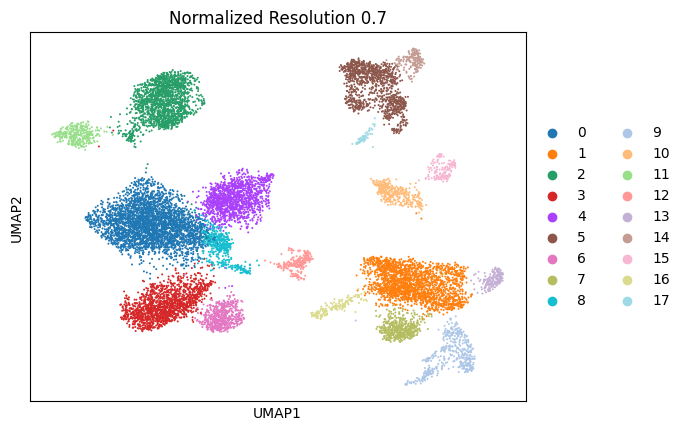

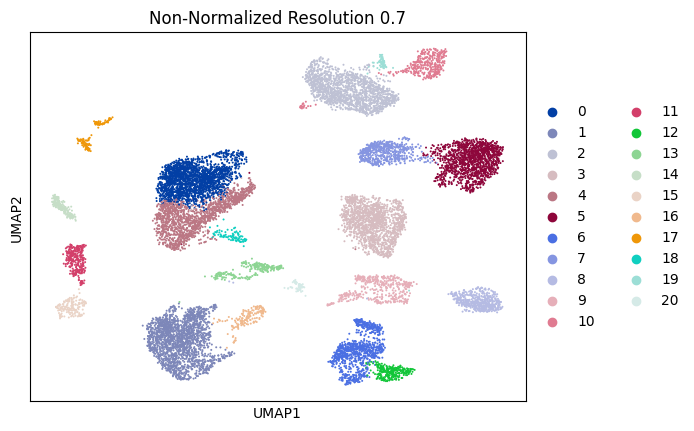

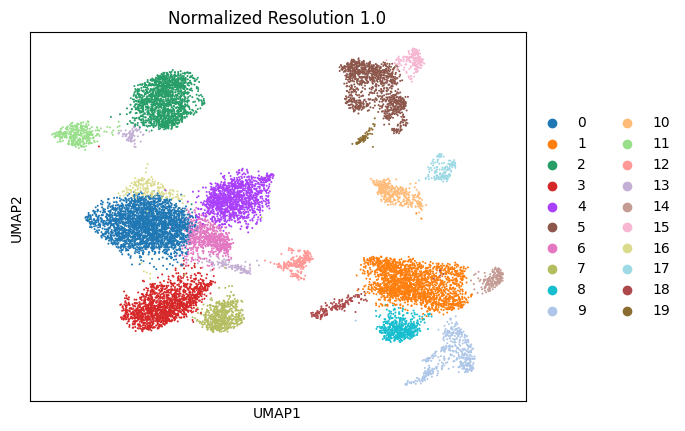

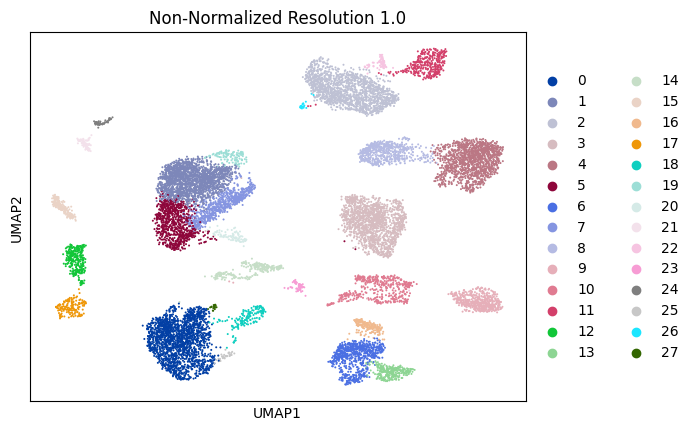

In [8]:
for idx, res in enumerate(resolutions):
    # Applying normalization and log to the data
    adata_norm = adata.copy()
    sc.pp.normalize_total(adata_norm, target_sum=1e4)
    sc.pp.log1p(adata_norm)
    # Identify the highly variable genes
    sc.pp.highly_variable_genes(adata_norm, min_mean=0.0125, max_mean=3, min_disp=0.5)
    # Scale the data
    sc.pp.scale(adata_norm, max_value=10)
    # Generate PCA features
    sc.tl.pca(adata_norm, svd_solver='arpack')
    # Compute distances in the PCA space, and find cell neighbors
    sc.pp.neighbors(adata_norm, n_neighbors=10, n_pcs=40)
    # Generate UMAP features
    sc.tl.umap(adata_norm)
    # Run leiden clustering algorithm
    sc.tl.leiden(adata_norm, resolution=res, key_added=f'leiden_res_{res}')
    # Store scores
    db_scores['normalized'][res] = davies_bouldin_score(adata_norm.obsm['X_umap'], adata_norm.obs[f'leiden_res_{res}'])
    # Visualize
    sc.pl.umap(adata_norm, color=f'leiden_res_{res}', title=f'Normalized Resolution {res}')
    plt.show()
    
    # Non-normalized analysis
    adata_non_norm = adata.copy()
    sc.pp.scale(adata_non_norm, max_value=10)
    sc.tl.pca(adata_non_norm, svd_solver='arpack')
    sc.pp.neighbors(adata_non_norm, n_neighbors=10, n_pcs=40)
    sc.tl.umap(adata_non_norm)
    sc.tl.leiden(adata_non_norm, resolution=res, key_added=f'leiden_res_{res}')
    db_scores['non_normalized'][res] = davies_bouldin_score(adata_non_norm.obsm['X_umap'], adata_non_norm.obs[f'leiden_res_{res}'])
    sc.pl.umap(adata_non_norm, color=f'leiden_res_{res}', title=f'Non-Normalized Resolution {res}')
    plt.show()

##### Print Davies-Bouldin scores for all resolutions

In [9]:
print("Davies-Bouldin Scores by Resolution:")
for res in resolutions:
    print(f"Resolution {res} - Normalized: {db_scores['normalized'][res]}, Non-Normalized: {db_scores['non_normalized'][res]}")


Davies-Bouldin Scores by Resolution:
Resolution 0.1 - Normalized: 0.5353348104406717, Non-Normalized: 0.6229013215521397
Resolution 0.3 - Normalized: 0.5442932449534232, Non-Normalized: 0.6111117044508014
Resolution 0.5 - Normalized: 0.546673571408675, Non-Normalized: 0.5397464782052909
Resolution 0.7 - Normalized: 0.5713160360290198, Non-Normalized: 0.6239388085591356
Resolution 1.0 - Normalized: 1.1840718778448123, Non-Normalized: 0.5912541734495854


#### As we increase the resolution, the number of clusters also increases. This can help us get a better insight into the data substrucures. Lower Davies-Bouldin scores indicate better clustering as clusters are more separated from each other. The results show how normalization impacts clustering quality differently at each resolution, which means that choosing the right resolution is one of the most important steps in this analysis.